# Time Series Forecasting (Continued)
**Project**: M5 Project 5
**Author**: Jacob Buysse

In this project we will be performing regression modeling on flights from the New York area and adding complimentary data to see how it improves perfromance.

In this notebook we will be using...

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
import seaborn as sns
import scipy
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

We will configure our plots for readable labels, high resolution, and automatic layout.

In [2]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150, autolayout=True)

## Part II

We will load our cleaned dataset and split it into a train/test set keeping the last year out for the testing set.

In [3]:
df = pd.read_feather('./counts.feather')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Columns: 139 entries, date to holiday_Western Easter -3
dtypes: bool(128), category(2), datetime64[ns](1), int64(8)
memory usage: 361.1 KB


In [4]:
test_mask = df.year == 2017
train_df = df[~test_mask]
test_df = df[test_mask]
print(f"Training size: {train_df.shape}, Testing size: {test_df.shape}")

Training size: (1461, 139), Testing size: (365, 139)


Linear Regression: r = -0.23832437454041616, p = 2.5812714220214682e-20, se = 0.006014670625694982


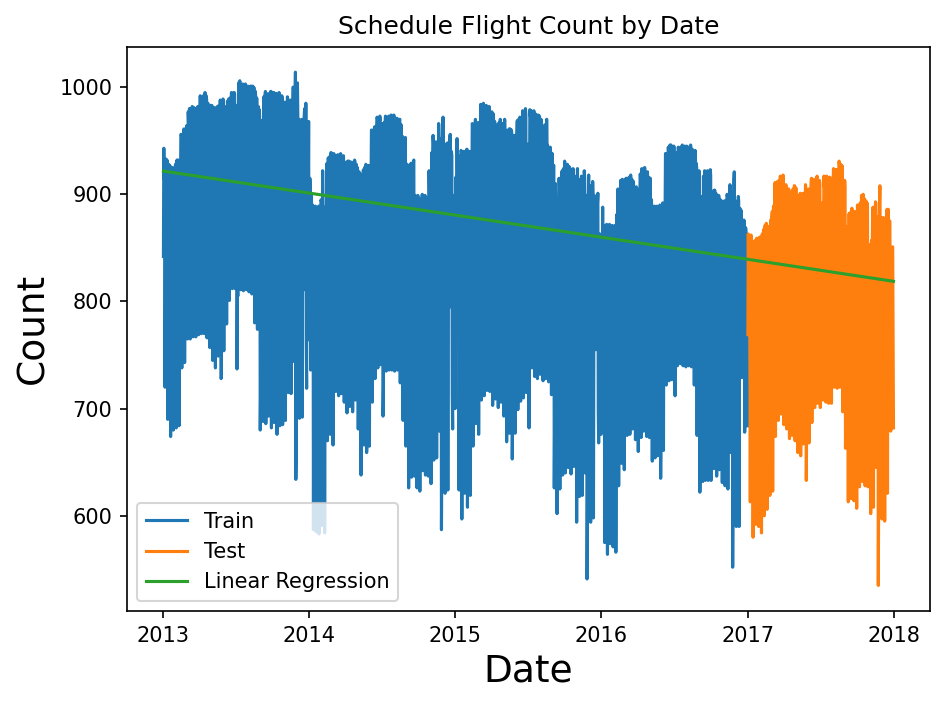

In [5]:
plot = sns.lineplot(train_df, x='date', y='count', label='Train')
sns.lineplot(test_df, x='date', y='count', label='Test')

first_date = datetime.datetime(year=2013, month=1, day=1)
last_date = datetime.datetime(year=2017, month=12, day=31)
train_day_serial = train_df.date.apply(lambda value: (value - first_date).days + 1)
slope, intercept, r, p, se = scipy.stats.linregress(train_day_serial, train_df['count'])
print(f"Linear Regression: r = {r}, p = {p}, se = {se}")
sns.lineplot(x=[first_date, last_date], y=[slope + intercept, slope * len(df) + intercept], label='Linear Regression')

plot.set(title='Schedule Flight Count by Date', xlabel='Date', ylabel='Count');
plot.figure.savefig('lr.png')

So there does appear to be a significant negative correlation between the date and the count.

## Part III

We will now model our data using Ridge regression with L2 regularization.  First we need to prepare our categorical data for training and scale our numeric data.

In [6]:
hot_enc = OneHotEncoder()
cat_features = ["month", "weekday"]
hot_enc.fit(train_df[cat_features])
train_hot = hot_enc.transform(train_df[cat_features])
test_hot = hot_enc.transform(test_df[cat_features])

Now we will scale our numeric features.

In [7]:
scaler = StandardScaler()
num_features = ["year", "doy", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]
scaler.fit(train_df[num_features])
train_num = scaler.transform(train_df[num_features])
test_num = scaler.transform(test_df[num_features])

We will continue to use the serial day number from the first date.  We just need to calculate the value for the testing set.

In [8]:
test_day_serial = test_df.date.apply(lambda value: (value - first_date).days + 1)

Next we will collect our boolean features.

In [9]:
bool_features = ["weekend", "leapday"] + df.columns[df.columns.str.contains("holiday_")].values.tolist()
train_bool = train_df[bool_features]
test_bool = test_df[bool_features]

And finally we combined all of the datasets into X,y for train and test.

In [10]:
train_X = sp.hstack((train_hot, train_num, pd.DataFrame(train_day_serial), train_bool))
train_y = train_df['count'].values
test_X = sp.hstack((test_hot, test_num, pd.DataFrame(test_day_serial), test_bool))
test_y = test_df['count'].values
print(f"Train X {train_X.shape}, y {len(train_y)}")
print(f"Test X {test_X.shape}, y {len(test_y)}")

Train X (1461, 155), y 1461
Test X (365, 155), y 365


Let us now do a Ridge regression.

In [11]:
model = Ridge(random_state=777, positive=True)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (Count): {rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (Count): 61, MAPE: 6.4%


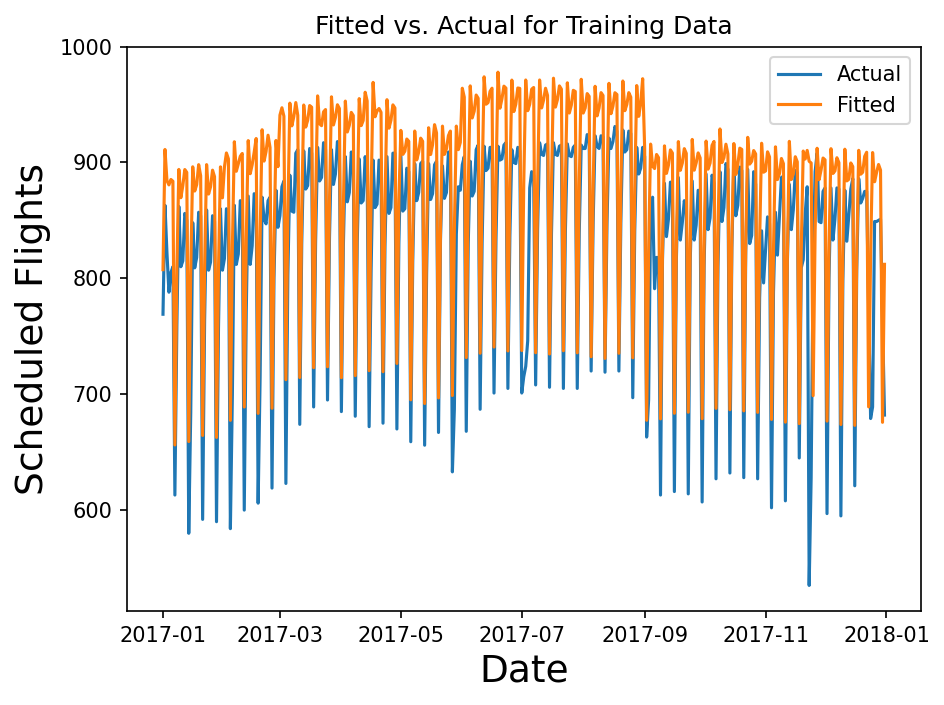

In [12]:
plot = sns.lineplot(x=test_df.date, y=test_y, label='Actual')
sns.lineplot(x=test_df.date, y=pred_y, label='Fitted')
plot.set(title='Fitted vs. Actual for Training Data', xlabel='Date', ylabel='Scheduled Flights');

Now let us compute the residuals and plot them.

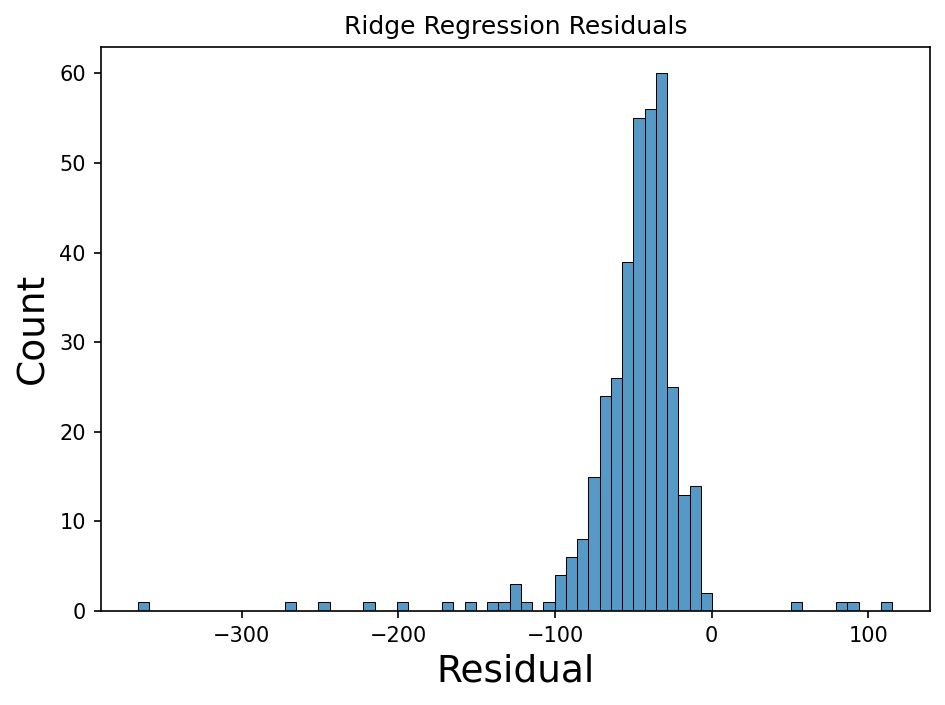

In [13]:
residuals = test_y - pred_y
plot = sns.histplot(residuals)
plot.set(title='Ridge Regression Residuals', xlabel='Residual');

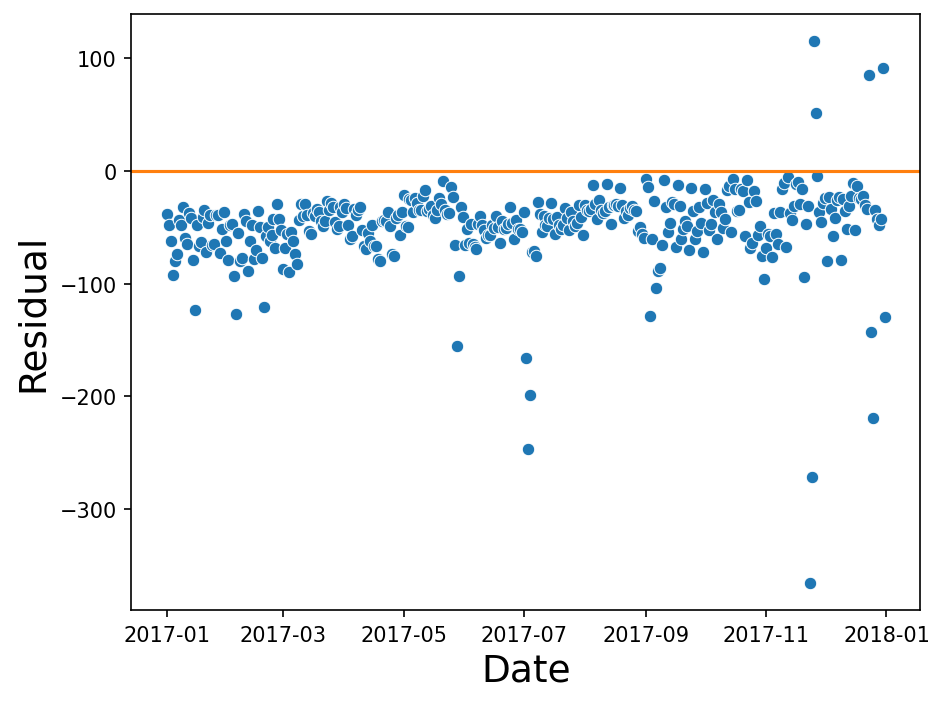

In [14]:
plot = sns.scatterplot(x=test_df.date, y=residuals)
plt.pyplot.axhline(y=0, color="tab:orange")
plot.set(xlabel="Date", ylabel="Residual");

We can see from these graphs that we are estimating too high when we are incorrect and almost never underestimating.  We can also see from the scatter plot that there are specific dates where the residual is much larger indicating that we may not be handling all of the seasonal dates correctly.

Per the instructions, we were to use the `postiive=True` attribute for the Ridge regression to prevent from estimate negative counts.  However, let us look at what our model and residuals look like without that property.

In [15]:
model = Ridge(random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (Count): {rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (Count): 26, MAPE: 2.2%


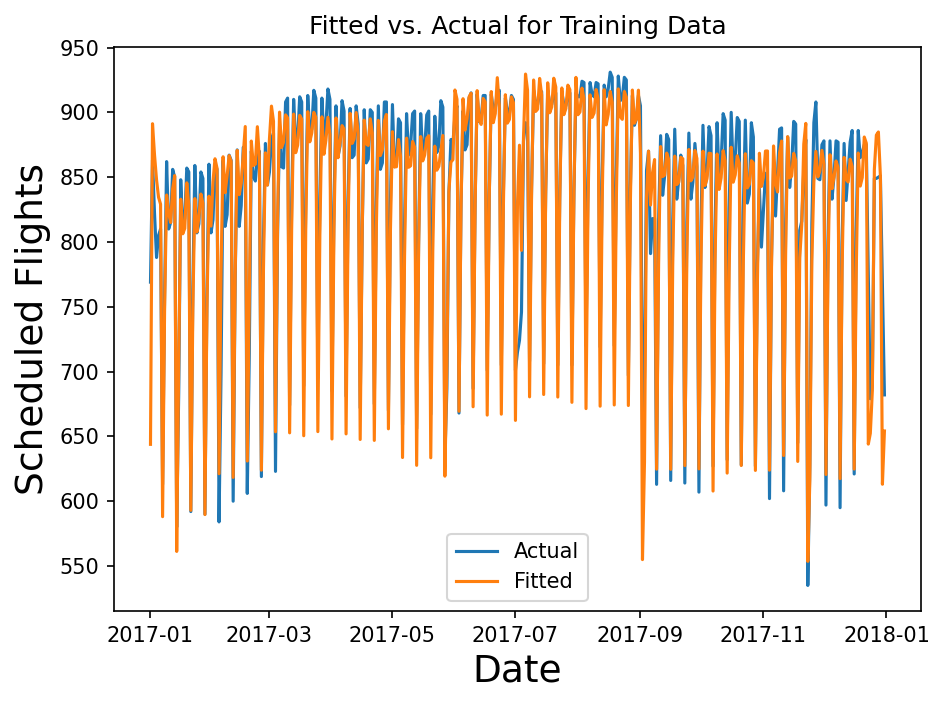

In [16]:
plot = sns.lineplot(x=test_df.date, y=test_y, label='Actual')
sns.lineplot(x=test_df.date, y=pred_y, label='Fitted')
plot.set(title='Fitted vs. Actual for Training Data', xlabel='Date', ylabel='Scheduled Flights');

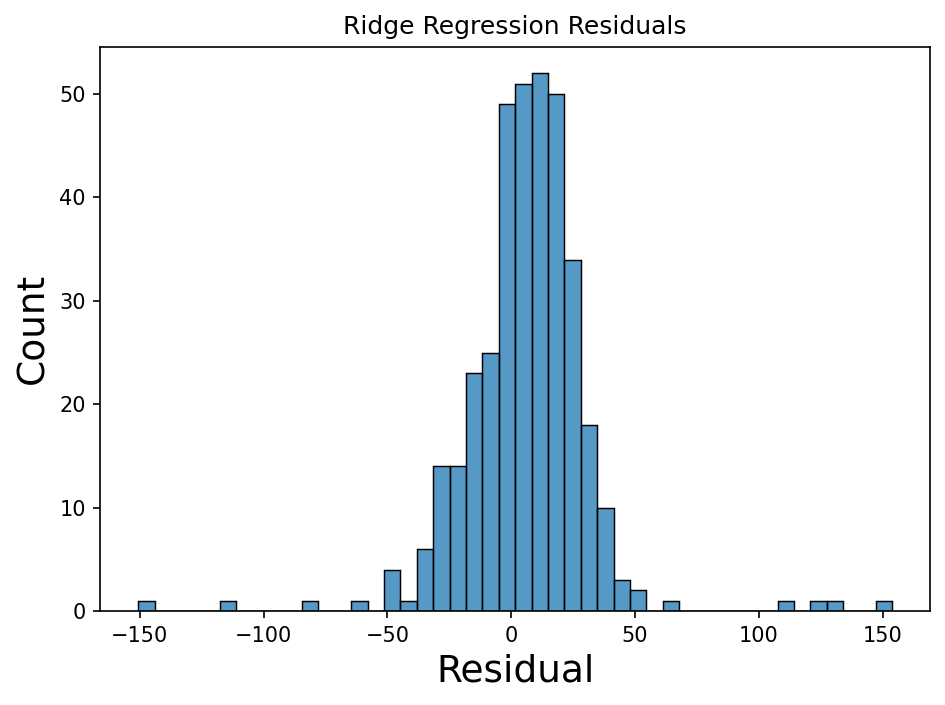

In [17]:
residuals = test_y - pred_y
plot = sns.histplot(residuals)
plot.set(title='Ridge Regression Residuals', xlabel='Residual');

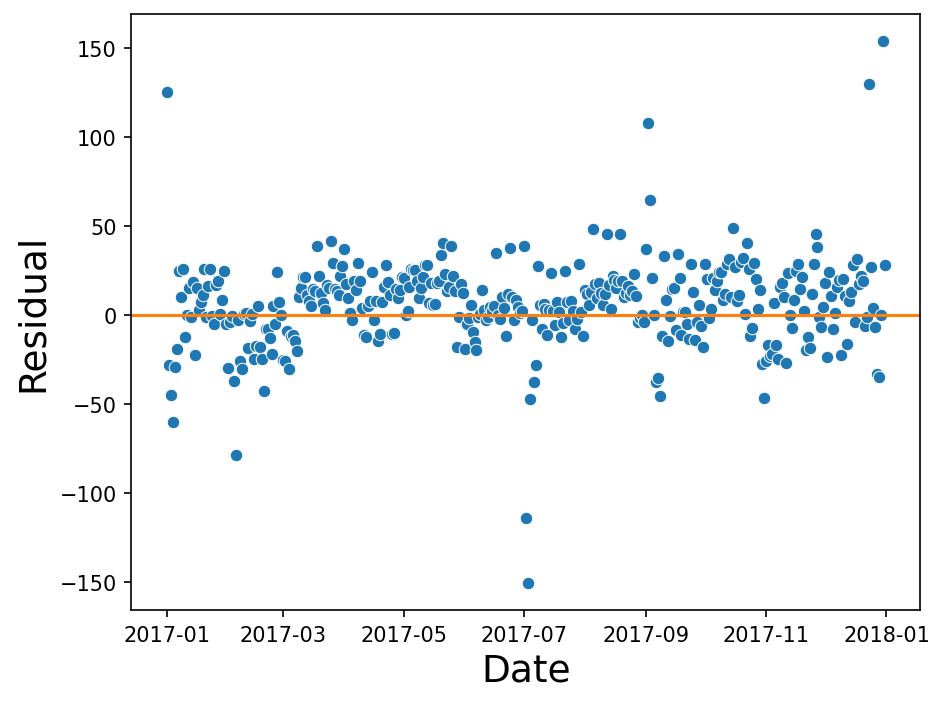

In [18]:
plot = sns.scatterplot(x=test_df.date, y=residuals)
plt.pyplot.axhline(y=0, color="tab:orange")
plot.set(xlabel="Date", ylabel="Residual");

We see that our RMSE is better (26 vs. 61) and our MAPE is also better (2.2% vs. 6.4%).  The graph of fitted vs. actual is better (peaks and troughs line up better) and our residuals appear to be centered around 0.  Since we didn't actually end up predicting negative values, I think that specifying the positive attribute for the Ridge regression may have been a incorrect premature optimization.

However, we still see several outliers in the +/- 100 count region (outside the normal distribution).  These appear to be located around the 4th of July, Christmas, New Years.  We included engineered features for 3 days before and after each holiday, but perhaps more careful analysis of specific days of the week before or after might be worth considering.

## TODO: Left off here - Try different models.